# 2DEG Electron Pump

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from bound import Bound

## Visualization of States

In [2]:
HBAR = 6.582e-16 # reduced Planck's constant [eV-s]
M_0 = 511000    # electron rest mass [eV] 
M_EFF = 0.98   # effective mass of electron

X_SCALE = 100.  # X-unit [ = 1A = 10^-8 cm]
X_SCALE_UNIT = 1e-10 # size of Angstrom [m]
V_DEPTH = 0.05 # boundary 2DEG well depth [eV]
E_F = 0.04 # Fermi level (relative to 2DEG well bottom) [eV]

In [3]:

def V_pump(x, V_ent, V_exit, 
            x_ent=4.*X_SCALE, 
            x_exit=6.*X_SCALE,
            w=0.8*X_SCALE, L=10*X_SCALE):
    """ Computes the gate-induced pump potential"""
    return V_ent*np.exp(-((x-x_ent)/w)**2) + \
           V_exit*np.exp(-((x-x_exit)/w)**2)

def V_pump_well(x, V_ent, V_exit, D=V_DEPTH):
    """ Computes the pump potential inside a 2DEG well"""
    
    well_idx = (x > .4*X_SCALE) & (x < 9.6*X_SCALE)
    if not np.isscalar(V_ent):
        V_ent  = V_ent[well_idx]
    if not np.isscalar(V_exit):
        V_exit = V_exit[well_idx]
    return np.piecewise(x, [well_idx], [ 
                          lambda x : V_pump(x,V_ent,V_exit),
                          lambda x : D,
                        ])
    
def V_gates_t(t, V_0, V_delta, theta=np.pi/2, omega=1.0):
    V_ent  = V_0 + V_delta*np.sin(omega*t)
    V_exit = V_0 + V_delta*np.sin(omega*t + theta)
    return V_ent, V_exit

In [4]:
# Set the quadrature points:
x_pts = np.linspace(0.0, 10, 1000)*X_SCALE
x_quad = np.linspace(0.0, 10., 256)*X_SCALE

V_0 = V_DEPTH/4
V_delta = V_DEPTH/4
V_omega = 2*np.pi*1e9 # [1GHz gate clocking]

<IPython.core.display.Javascript object>


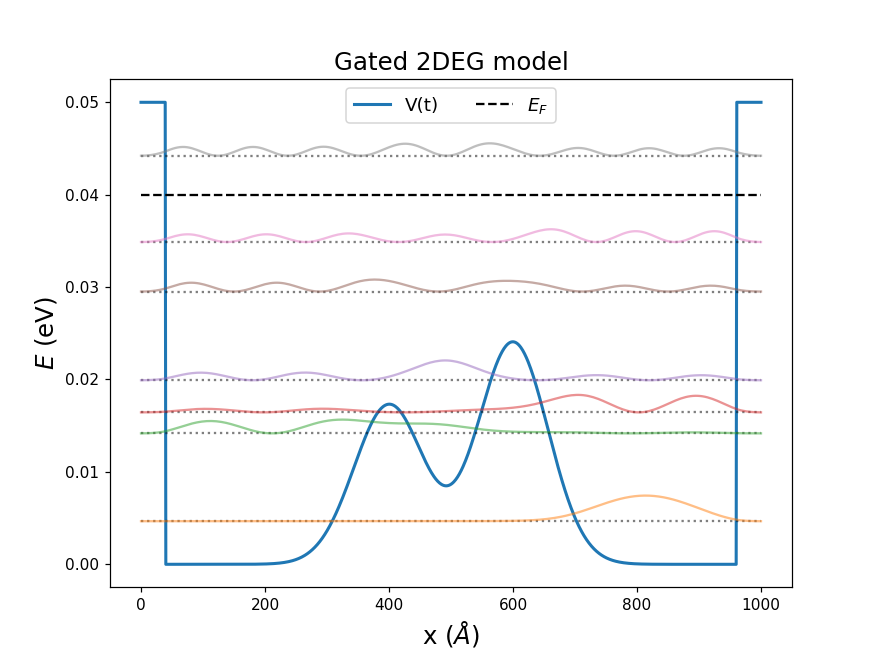

In [15]:
%matplotlib notebook

# numerically solve SE for stationary states:
t_0 = np.pi/8 / V_omega

V_gates = V_gates_t(t_0, V_0, V_delta, omega=V_omega)
V_pts = V_pump_well(x_pts, *V_gates)
V_quad = V_pump_well(x_quad, *V_gates)
psis, Es = Bound(V_quad, x_quad)
psis = psis.T
psi_amp = V_DEPTH*10

# plot energy levels:
plt.figure(figsize=(8,6))
plt.plot(x_pts, V_pts, linewidth=2., label='V(t)')
for psi_i, E_i in zip(psis[1:], Es[1:]):
    if E_i > V_DEPTH:
        break
    plt.plot(x_pts, np.ones_like(x_pts)*E_i, ':k', alpha=0.5)
    plt.plot(x_quad, psi_amp*np.abs(psi_i)**2 + E_i,
             alpha=0.5)
    
# plot Fermi level and potential:
plt.plot(x_pts, np.ones_like(x_pts)*E_F, 
         '--k', label=r'$E_F$')
plt.legend(ncol=2, loc='upper center', fontsize=12)
plt.xlabel(r'x ($\AA$)', fontsize=16)
plt.ylabel(r'$E$ (eV)', fontsize=16)
plt.title('Gated 2DEG model', fontsize=16)
plt.show()

In [6]:
gate_t_vals = np.linspace(0.0, 2*np.pi, 500)/V_omega
E_results = []
psi_results = []
V_pts_results = []

for t in tqdm(gate_t_vals):
    V_gates = V_gates_t(t, V_0, V_delta, omega=V_omega)
    V_quad = V_pump_well(x_quad, *V_gates)
    V_pts = V_pump_well(x_pts, *V_gates)
    
    psis, Es = Bound(V_quad, x_quad)
    psis = psis.T
    
    E_results.append(Es[1:8])
    psi_results.append(psis[1:8])
    V_pts_results.append(V_pts)

E_results = np.array(E_results)
psi_results = np.array(psi_results)
V_pts_results = np.array(V_pts_results)


  0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


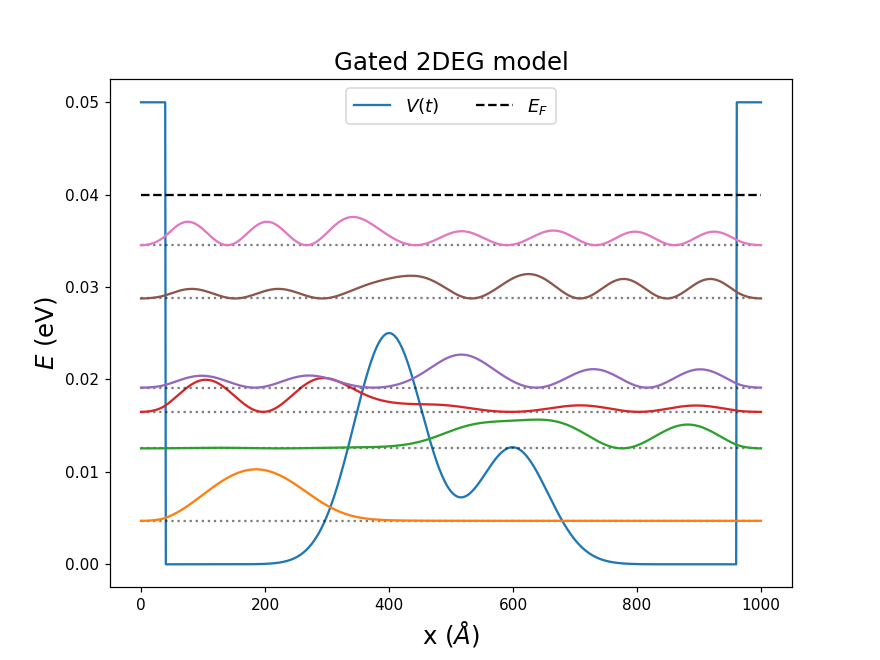

In [14]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
V_plot, = ax.plot(x_pts,V_pts_results[0], label=r'$V(t)$')
EF_plot, = ax.plot(x_quad, np.ones_like(x_quad)*E_F, 
                   'k--', label=r'$E_F$')
rho_plots, E_plots = [], []
psis, Es = psi_results[0], E_results[0]
densities = psis * psis.conj()

ax.set_xlabel(r'x ($\AA$)', fontsize=16)
ax.set_ylabel(r'$E$ (eV)', fontsize=16)
ax.set_title('Gated 2DEG model', fontsize=16)
ax.legend(ncol=2, loc='upper center', fontsize=12)

for rho, E in zip(densities, Es):
    E_plots.append(ax.plot([],[],':k', alpha=0.5)[0])
    rho_plots.append(ax.plot([],[])[0])

def init_plot():
    # return artist objects:
    return tuple([EF_plot, V_plot] + E_plots + rho_plots)
    
def animate(i):
    psis = psi_results[i]
    Es = E_results[i]
    densities = psis * psis.conj()
    
    V_plot.set_data(x_pts,V_pts_results[i])
    for i, rho in enumerate(densities):
        if Es[i] < E_F:
            E_plots[i].set_data(x_quad, Es[i]*np.ones_like(x_quad))
            rho_plots[i].set_data(x_quad, rho + Es[i])
        else:
            E_plots[i].set_data([],[])
            rho_plots[i].set_data([],[])
    
    return tuple([EF_plot, V_plot] + E_plots + rho_plots)
    
ani = FuncAnimation(fig, animate, init_func=init_plot, 
                     frames=len(gate_t_vals),interval=50, blit=True)
plt.show()

## Simulation of Gate Tunneling

In [8]:
# numerically solve SE for stationary states:
t_0 = np.pi/8 / V_omega

def psi_gaussian(x_quad, x_0, sigma_0):
    psi = np.exp(-((x_quad-x_0)/sigma_0)**2)
    return psi / np.sqrt(np.trapz(psi*psi.conj(), x_quad))

def localized_psi_0(x_quad, V_quad, x_0, N=6):
    phis, Es = Bound(V_quad, x_quad)
    phis = phis.T
    psi_0 = psi_gaussian(x_quad, x_0, X_SCALE*2)
    phi_cs = np.array([ 
        np.trapz(phi.conj()*psi_0,x_quad) 
        for phi in phis 
    ])
    trunc_Es = Es[:N]
    trunc_phis = phis[:N]
    trunc_cs = phi_cs[:N] / \
            np.sqrt(np.sum(np.abs(phi_cs[:N])**2))
    return trunc_phis, trunc_cs, trunc_Es


In [9]:
V_gates = V_gates_t(t_0, V_0, V_delta, omega=V_omega)
V_pts = V_pump_well(x_pts, *V_gates)
V_quad = V_pump_well(x_quad, *V_gates)

x_0 = X_SCALE*5
N_0 = 6
phi_states, phi_cs, phi_Es = localized_psi_0(x_quad, V_quad, x_0, N = N_0)

E_min, E_max = np.min(phi_Es[phi_Es > 0.0]), np.max(phi_Es)
tau_min = (2*np.pi*HBAR) / E_max
tau_max = (2*np.pi*HBAR) / E_min

print('Minimal Tunneling period:', '%.3e' % tau_min, '(s)')
print('Maximal Tunneling period:', '%.3e' % tau_max, '(s)')

Minimal Tunneling period: 1.401e-13 (s)
Maximal Tunneling period: 9.565e-13 (s)


In [10]:
def rho_t(t, phi_states, phi_cs, phi_Es):
    psi_t = np.zeros_like(phi_states[0], dtype=np.complex128)
    for phi, c, E in zip(phi_states, phi_cs, phi_Es):
        psi_t += c*np.exp(-1.j*E*t/HBAR)*phi
    return np.abs(psi_t * np.conj(psi_t))


t_vals = np.linspace(0.0, 2*tau_max, 1000)
rho_vals = np.array([
    rho_t(t,phi_states, phi_cs, phi_Es)
    for t in tqdm(t_vals)
])
rho_E = np.sum(np.abs(phi_cs)**2 * phi_Es)

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


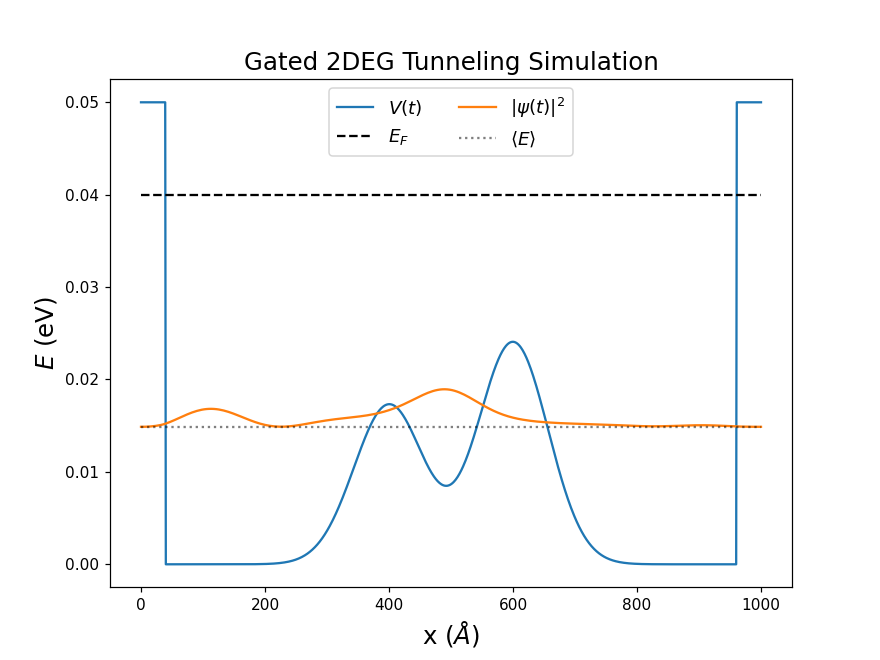

In [11]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
V_plot, = ax.plot(x_pts,V_pts, label=r'$V(t)$')
EF_plot, = ax.plot(x_quad, np.ones_like(x_quad)*E_F, 
                   'k--', label=r'$E_F$')

ax.set_xlabel(r'x ($\AA$)', fontsize=16)
ax.set_ylabel(r'$E$ (eV)', fontsize=16)
ax.set_title('Gated 2DEG Tunneling Simulation', fontsize=16)

rho_plot, = ax.plot(x_quad, rho_E+rho_vals[0], label=r'$|\psi(t)|^2$')
E_plot, = ax.plot(x_quad, rho_E*np.ones_like(x_quad), 
                  ':k', alpha=0.5,label=r'$\langle E \rangle$')    
ax.legend(ncol=2, loc='upper center', fontsize=12)


def animate_rho(i):
    rho_plot.set_data(x_quad, rho_E+rho_vals[i])
    return rho_plot
    
rho_ani = FuncAnimation(fig, animate_rho,frames=len(rho_vals),interval=5, blit=True)
plt.show()